In [235]:
filename = './datasets.json.gz'
if not os.path.exists(filename):
    url = 'https://paperswithcode.com/media/about/datasets.json.gz'
    myfile = requests.get(url)
    with open(filename, 'wb') as o:
        o.write(myfile.content)
    with gzip.open(filename, 'rb') as f_in:
        with open('./datasets.json', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

with open('datasets.json') as f:
    datasets_ = json.load(f)
    
variant_to_parent = dict()
variant_to_url = dict()
# unprioritize independency
for dataset in datasets_:
    variant_to_parent[dataset["name"]] = dataset["name"]
    variant_to_url[dataset["name"]] = dataset["url"]
for dataset in datasets_:
    ## create variant_to_parent mapping 
    for variant in dataset["variants"]:
        if dataset["name"] != variant:
            variant_to_parent[variant] = dataset["name"]
            variant_to_url[dataset["name"]] = dataset["url"]

In [236]:
import os
import random
import string
import re
import requests
import gzip
import shutil
import json
import types
import datetime
import decimal
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt

endpoint = "http://193.171.177.138:9999/blazegraph/sparql"  # SPARQL endpoint hosting previous version of ITO.owl
prefixes = """
prefix owl: <http://www.w3.org/2002/07/owl#>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>
prefix ito: <https://identifiers.org/ito:>
prefix edam: <http://edamontology.org/>
prefix obo: <http://www.geneontology.org/formats/oboInOwl#>
prefix dc: <http://purl.org/dc/elements/1.1/>
"""


def query(query, return_format = JSON):
    sparql = SPARQLWrapper(endpoint)
    sparql.method = 'POST'
    sparql.setReturnFormat(return_format)
    sparql.setQuery(prefixes + query)
    results = sparql.query().convert()
    return results


def query_df(query, numeric_cols = []):
    # Run SPARQL query, and convert results to Pandas dataframe
    sparql = SPARQLWrapper(endpoint)
    sparql.method = 'POST'
    sparql.setReturnFormat(JSON)
    sparql.setQuery(prefixes + query)
    results = sparql.query()
    processed_results = json.load(results.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)
        
    df = pd.DataFrame(out, columns=cols)
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col])
    
    return df

def tasks_stat_dict(df):
    from collections import defaultdict
    tasks_stat = defaultdict(int)
    for idx, row in df.iterrows():
        for task in row["tasks"]:
            tasks_stat[task] += 1
    return dict(sorted(tasks_stat.items(), key=lambda x: x[1], reverse=True))
    

Description whole df
       n_entries    n_tasks
count  90.000000  90.000000
mean    6.388889   1.388889
std     6.939052   0.830520
min     1.000000   1.000000
25%     2.000000   1.000000
50%     4.000000   1.000000
75%     8.000000   1.000000
max    47.000000   5.000000
Length popular 21
Length unpopular 24


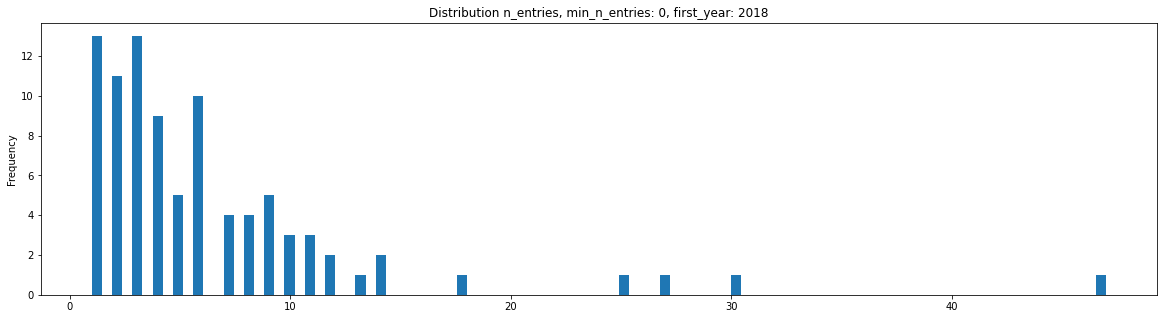

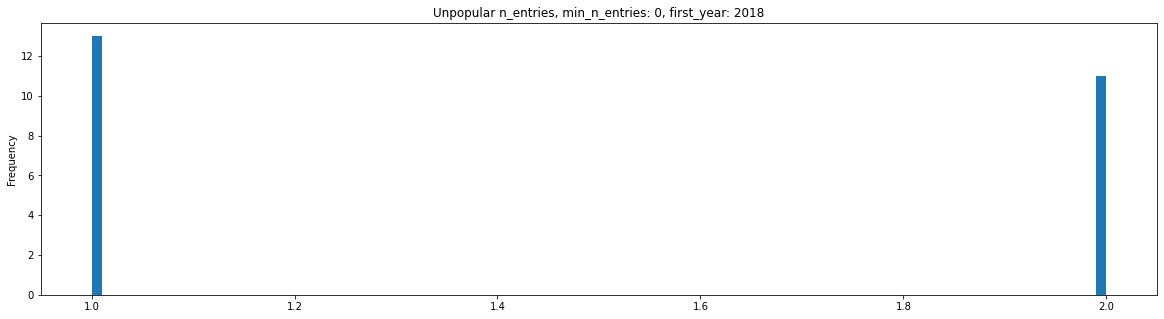

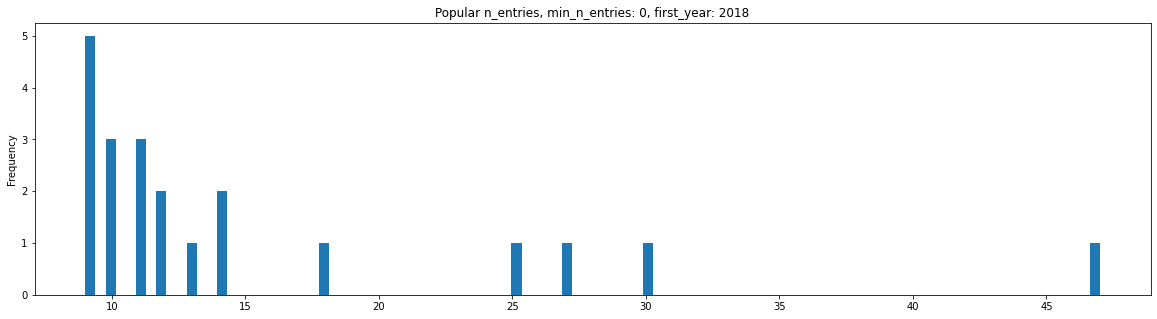

In [250]:
first_year = 2018
min_n_entries = 0

df = query_df("""
SELECT * WHERE {
    ?benchmark rdfs:subClassOf+ <https://identifiers.org/ito:ITO_00101> .
    ?benchmark rdfs:subClassOf <https://identifiers.org/ito:Benchmarking> .
    ?benchmark rdfs:label ?benchmark_label .
    ?result rdf:type ?benchmark .
    ?result obo:date ?date .
}
""")
df["benchmark_label"] = df["benchmark_label"].str.replace(" benchmarking", "")
df[["benchmark_label", "task_label"]] = df["benchmark_label"].str.split(' - ', 1, expand=True)
df["date"] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.sort_values(by="date")

df["benchmark_label"] = df["benchmark_label"].apply(lambda x: variant_to_parent.get(x, None))
df = df.dropna(subset=["benchmark_label"])

def agg(examples):
    examples = examples.sort_values(by="date")
    return pd.Series({"first_date": examples.iloc[0]["date"], "n_entries": len(examples), "n_tasks": len(set(examples["task_label"])), "tasks": set(examples["task_label"])})

df = df.groupby(["benchmark_label"])[["result", "date", "task_label"]].apply(agg).reset_index()
df["url"] = df["benchmark_label"].apply(lambda x: variant_to_url.get(x, None))
df = df.sort_values(by="n_entries", ascending=False)

df.to_csv("all_unfiltered.csv", header=None, index=None)

# filter year
if first_year > -1:
    df = df[df['first_date'].dt.year == first_year]

# filter n_entries
df = df[df.n_entries >= min_n_entries]

description = df.describe()
print("Description whole df")
print(description)

plt.figure();
df["n_entries"].plot.hist(stacked=True, bins=100, figsize=(20,5), title=f"Distribution n_entries, min_n_entries: {min_n_entries}, first_year: {first_year}");

unpopular = df[df.n_entries <= float(description["n_entries"].loc["25%"])]
popular = df[df.n_entries > float(description["n_entries"].loc["75%"])]

print(f"Length popular {len(popular)}")
print(f"Length unpopular {len(unpopular)}")

plt.figure();
unpopular["n_entries"].plot.hist(stacked=True, bins=100, figsize=(20,5), title=f"Unpopular n_entries, min_n_entries: {min_n_entries}, first_year: {first_year}");
plt.figure();
popular["n_entries"].plot.hist(stacked=True, bins=100, figsize=(20,5), title=f"Popular n_entries, min_n_entries: {min_n_entries}, first_year: {first_year}");

In [251]:
popular.iloc[0:30]

,benchmark_label,first_date,n_entries,n_tasks,tasks,url
500,RefCOCO,2018-01-24,47,1,{Referring Expression Segmentation},https://paperswithcode.com/dataset/refcoco
440,Oxford-IIIT Pets,2018-05-24,30,3,"{Image Classification, Image Compression, Fine...",https://paperswithcode.com/dataset/oxford-iiit...
299,ImageNet-C,2018-11-29,27,2,"{Unsupervised Domain Adaptation, Domain Genera...",https://paperswithcode.com/dataset/imagenet-c
215,FC100,2018-05-23,25,1,{Few-Shot Image Classification},https://paperswithcode.com/dataset/fc100
560,SoccerNet-v2,2018-04-12,18,4,"{Camera shot segmentation, Action Spotting, Re...",https://paperswithcode.com/dataset/soccernet-v2
282,ICDAR 2017,2018-01-05,14,1,{Scene Text Detection},https://paperswithcode.com/dataset/icdar-2017
517,SHREC,2018-01-21,14,4,"{3D Object Recognition, Hand Gesture Recogniti...",https://paperswithcode.com/dataset/shrec
200,ETH,2018-03-29,13,1,{Trajectory Prediction},https://paperswithcode.com/dataset/eth
240,Foggy Cityscapes,2018-03-08,12,3,"{Image-to-Image Translation, Unsupervised Doma...",https://paperswithcode.com/dataset/foggy-citys...
644,VehicleID,2018-11-13,12,1,{Vehicle Re-Identification},https://paperswithcode.com/dataset/vehicleid


In [252]:
popular.describe()

,n_entries,n_tasks
count,21.000000,21.000000
mean,15.238095,1.714286
std,9.559837,1.055597
min,9.000000,1.000000
25%,10.000000,1.000000
50%,11.000000,1.000000
75%,14.000000,2.000000
max,47.000000,4.000000


In [253]:
tasks_stat_dict(popular)

{'Fine-Grained Image Classification': 2,
 'Unsupervised Domain Adaptation': 2,
 'Image Denoising': 2,
 'Lipreading': 2,
 'Referring Expression Segmentation': 1,
 'Image Classification': 1,
 'Image Compression': 1,
 'Domain Generalization': 1,
 'Few-Shot Image Classification': 1,
 'Camera shot segmentation': 1,
 'Action Spotting': 1,
 'Replay Grounding': 1,
 'Camera shot boundary detection': 1,
 'Scene Text Detection': 1,
 '3D Object Recognition': 1,
 'Hand Gesture Recognition': 1,
 'Skeleton Based Action Recognition': 1,
 'Point Cloud Super Resolution': 1,
 'Trajectory Prediction': 1,
 'Image-to-Image Translation': 1,
 'Weakly Supervised Object Detection': 1,
 'Vehicle Re-Identification': 1,
 'Semantic Segmentation': 1,
 'Visual Place Recognition': 1,
 'Panoptic Segmentation': 1,
 'Human-Object Interaction Detection': 1,
 'Unconstrained Lip-synchronization': 1,
 'Image Dehazing': 1,
 'Visual Question Answering': 1,
 'Face Alignment': 1,
 'Text based Person Retrieval': 1,
 'Semantic cor

In [254]:
unpopular.iloc[0:30]

,benchmark_label,first_date,n_entries,n_tasks,tasks,url
521,SK-LARGE,2018-01-05,2,1,{Object Skeleton Detection},https://paperswithcode.com/dataset/sk-large
556,Sim10k,2018-12-12,2,1,{Unsupervised Domain Adaptation},https://paperswithcode.com/dataset/sim10k
144,Cluttered Omniglot,2018-03-26,2,1,{One-Shot Segmentation},https://paperswithcode.com/dataset/cluttered-o...
526,SSIG-SegPlate,2018-02-26,2,1,{License Plate Recognition},https://paperswithcode.com/dataset/ssig-segplate
148,Color FERET,2018-10-26,2,1,{Face Recognition},https://paperswithcode.com/dataset/color-feret
149,Comic2k,2018-03-30,2,1,{Weakly Supervised Object Detection},https://paperswithcode.com/dataset/comic2k
294,IconArt,2018-10-05,2,1,{Weakly Supervised Object Detection},https://paperswithcode.com/dataset/iconart
340,Letter,2018-12-11,2,1,{Image Clustering},https://paperswithcode.com/dataset/letter
376,MSRC-12,2018-11-17,2,2,"{Gesture Recognition, Skeleton Based Action Re...",https://paperswithcode.com/dataset/msrc-12
382,Make3D,2018-06-04,2,1,{Monocular Depth Estimation},https://paperswithcode.com/dataset/make3d


In [255]:
unpopular.describe()

,n_entries,n_tasks
count,24.000000,24.000000
mean,1.458333,1.041667
std,0.508977,0.204124
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,1.000000
max,2.000000,2.000000


In [256]:
tasks_stat_dict(unpopular)

{'License Plate Recognition': 2,
 'Weakly Supervised Object Detection': 2,
 'Steering Control': 2,
 'Object Skeleton Detection': 1,
 'Unsupervised Domain Adaptation': 1,
 'One-Shot Segmentation': 1,
 'Face Recognition': 1,
 'Image Clustering': 1,
 'Gesture Recognition': 1,
 'Skeleton Based Action Recognition': 1,
 'Monocular Depth Estimation': 1,
 'Visual Question Answering': 1,
 'Unseen Object Instance Segmentation': 1,
 'Trajectory Prediction': 1,
 'Human Instance Segmentation': 1,
 'Domain Adaptation': 1,
 'Gaze Estimation': 1,
 'Retinal Vessel Segmentation': 1,
 'Motion Segmentation': 1,
 '3D Face Animation': 1,
 'Object Localization': 1,
 '2D Object Detection': 1}

In [257]:
popular.to_csv("popular.csv", header=None, index=None)
unpopular.to_csv("unpopular.csv", header=None, index=None)